# Potato Disease Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Import data into tensorflow dataset object

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size= 32
)

Found 2096 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
len(dataset)

66

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


## Visualize some of the images from our dataset

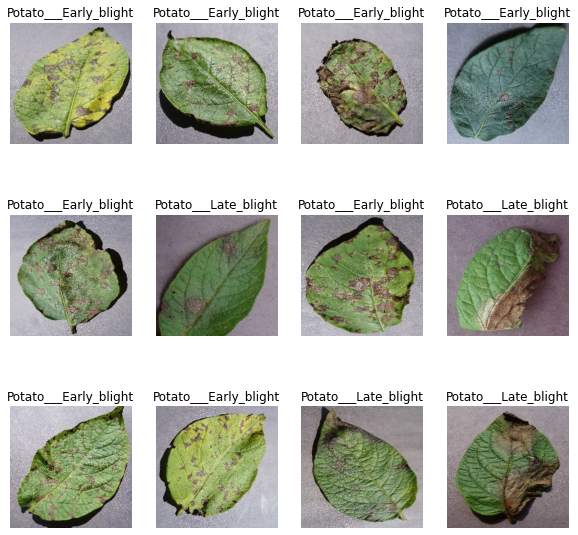

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Split Dataset 

Dataset should be divided into 3 subsets, namely:

  1. Training: Dataset to be used while training
  2. Validation: Dataset to be tested against while training
  3.Test: Dataset to be tested against after we trained a model

In [7]:
train_ds = dataset.take(54)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(54)
len(test_ds)

12

In [9]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [10]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [13]:
len(train_ds), len(val_ds), len(test_ds)

(52, 6, 8)

Cache, Shuffle, and Prefetch the Dataset

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

In [15]:
IMAGE_SIZE =256 
BATCH_SIZE = 32

### Creating a Layer for Resizing and Normalization

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Architecture of Sequntial Model 

A CNN coupled with a Softmax activation in the output layer.also add the initial layers for resizing, normalization and Data Augmentation.

In [17]:
input_shape = (32,256,256,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model :
Use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
52/52 [==============================] - 94s 2s/step - loss: 0.8380 - accuracy: 0.5102 - val_loss: 0.8002 - val_accuracy: 0.7083
Epoch 2/20
52/52 [==============================] - 84s 2s/step - loss: 0.6591 - accuracy: 0.7007 - val_loss: 0.6216 - val_accuracy: 0.7396
Epoch 3/20
52/52 [==============================] - 87s 2s/step - loss: 0.5280 - accuracy: 0.7873 - val_loss: 0.5139 - val_accuracy: 0.7917
Epoch 4/20
52/52 [==============================] - 88s 2s/step - loss: 0.3795 - accuracy: 0.8498 - val_loss: 0.4212 - val_accuracy: 0.8229
Epoch 5/20
52/52 [==============================] - 92s 2s/step - loss: 0.2928 - accuracy: 0.8828 - val_loss: 0.2907 - val_accuracy: 0.8594
Epoch 6/20
52/52 [==============================] - 87s 2s/step - loss: 0.2536 - accuracy: 0.9002 - val_loss: 0.2798 - val_accuracy: 0.8802
Epoch 7/20
52/52 [==============================] - 92s 2s/step - loss: 0.1731 - accuracy: 0.9357 - val_loss: 0.2440 - val_accuracy: 0.8958
Epoch 8/20
52/52 [==

In [21]:
# Model evaluate on test dataset
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 429ms/step - loss: 0.1028 - accuracy: 0.9766


above that get 98.80% accuracy for traing dataset.                                                                           
above that get 97.66% accuracy for test dataset. 

### Plotting the Accuracy and Loss Curves

In [22]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 52}

In [23]:
type(history.history['loss'])

list

In [24]:
len(history.history['loss'])

20

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8379648923873901,
 0.6590920090675354,
 0.5279527306556702,
 0.3795493543148041,
 0.29275625944137573]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 20

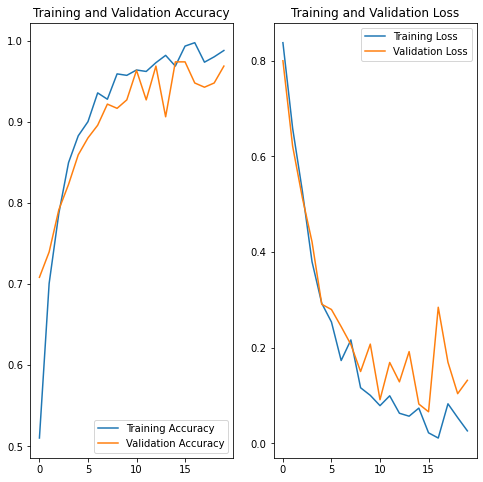

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


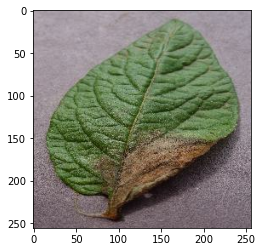

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


### Write a function for inference

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Run inference on few sample images

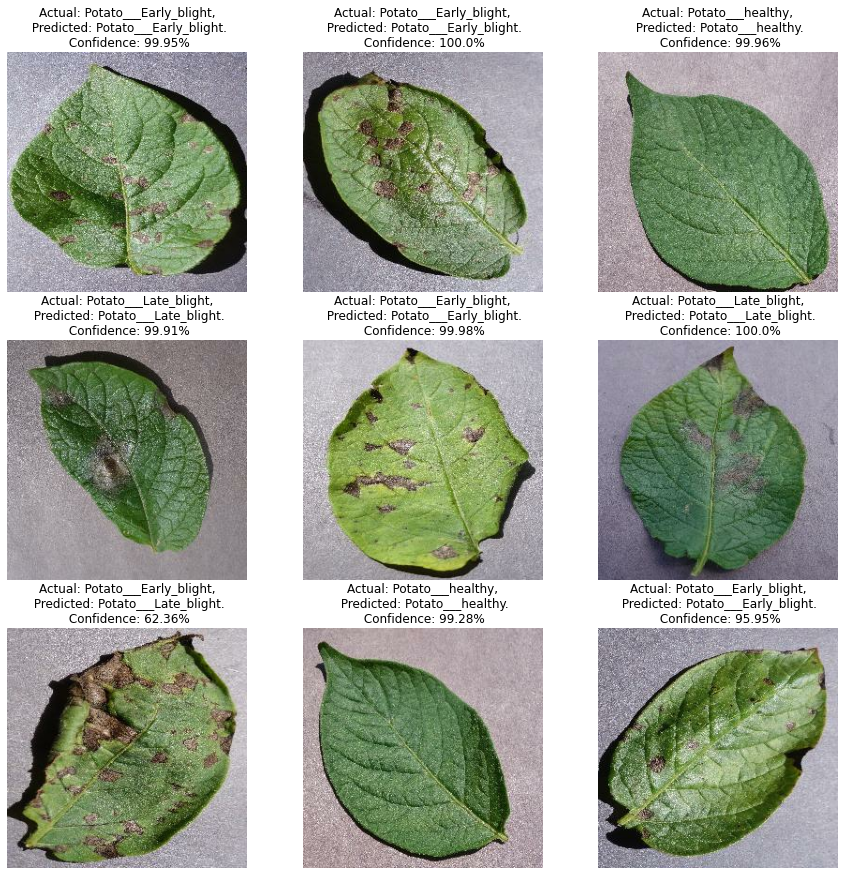

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
model.save("../potatoes.h5")